# Много гипотез

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Задание 1 (мудрость)

> Помните, что для человека звук его имени является самым сладким и самым важным звуком человеческой речи. (Дейл Карнеги)

Доверяй, но проверяй. Решим задачку по психологии! Все цитаты в пабликах вконтакте делятся на два вида: мудрые и недостаточно мудрые. Если цитата мудрая, то её можно лайкнуть. Поговаривают, что если в цитате есть личные местоимения, то пользователь автоматически сопоставляет себя автору этой цитаты и вероятность того, что она будет лайкнута, повышается. Например, цитату 

> Можно простить человеку все, кроме отсутствия. (Экзюпери) 

мне не очень хотелось бы лайкать. А вот цитата 

> Мне наплевать, что вы обо мне думаете. Я о вас вообще не думаю. (Булгаков) 

совершенно другое дело. 

В табличке `df_vk_wise` лежат данные о мудрых цитатах из [мудрого паблика.](https://vk.com/ooioioioioioo) В колонке `I` находится переменная, которая принимает значение `True`, когда в тексте цитаты было личное местоимение "Я".

Срежем первые $50$ постов, так как под ними количество репостов и лайков ещё окончательно не выставлено, и будем работать с остатками. 

In [2]:
df = pd.read_csv('data/df_vk_wise.csv')[50:]
df.head()

,likes,reposts,text,I
50,549,25,"Я, говорит, люблю человечество, но дивлюсь на ...",True
51,607,22,"Нельзя любить то, что я люблю, да ещё так, как...",True
52,914,37,Если испытываешь по-настоящему глубокое чувств...,False
53,989,34,"— Я тебя люблю, — сказал я. \n— Это пройдет, —...",True
54,1229,32,"Он очаровательно рассказывает мне о том, как о...",False


Постройте гистограмму для числа лайков постов, содержащих личные местоимения и не содержащих. Как думаете, есть ли с распределением лайков какие-то проблемы?

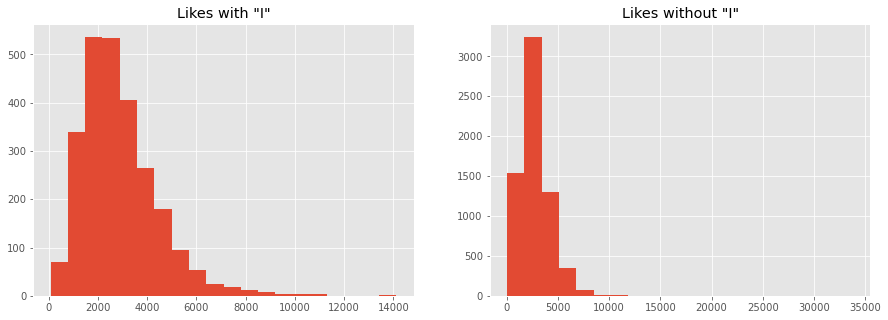

In [3]:
# your code here
x = df[df.I == 1].likes.values
y = df[df.I == 0].likes.values

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(x, bins=20)
axs[0].set_title('Likes with "I"')
axs[1].hist(y, bins=20)
axs[1].set_title('Likes without "I"');

Да, проблемы есть. Это выбросы. Хвосты на гистограммах оказываются очень длинными.<br>

Найдите медианы и средние для числа лайков. Сравните их между собой.

In [4]:
# your code here
agg = df.groupby('I', as_index=False) \
    .agg({'likes': ['mean', 'median']}) \
    .round()

agg.columns = ['likes_with_I', 'mean', 'median']
agg

,likes_with_I,mean,median
0,False,2784.0,2497.0
1,True,2879.0,2588.0


Проверьте гипотезу о равенстве среднего числа лайков. Используйте для этого $z$-тест, основанный на ЦПТ. Дисперсию расчитывайте по выборке, используя несмещённую оценку `(ddof=1)`. Запишите наблюдаемое значение статистики в переменную `z_obs`.

$$ H_0: \hspace{2mm} \mu_1 = \mu_2  \hspace{2mm} \text{Среднее число лайков одинаковое} $$
$$ H_a: \hspace{2mm} \mu_1 \ne \mu_2  \hspace{2mm} \text{Среднее число лайков с I отличается} $$

In [5]:
# your code here
alpha = 0.05

nx, ny = x.size, y.size

diff = x.mean() - y.mean()
diff_std = np.sqrt(x.var(ddof=1) / nx + y.var(ddof=1) / ny)

z_obs = diff/diff_std

Найдите критическое значение статистики. Сравните его с наблюдаемым. Рассчитайте p-value для ситуации с двусторонней альтернативой. Сделайте вывод о выдвинутой гипотезе. Критическое значение статистики запишите в переменную `z_crit`, а p-значение в переменную `pval`.

In [6]:
# your code here
z_crit = sts.norm.ppf(1 - alpha/2)
pval = 2 * (1 - sts.norm().cdf(z_obs))

print(f'Наблюдаемое значение {z_obs:.4} больше критического {z_crit:.4}. P-value: {pval:.1}')

Наблюдаемое значение 2.664 больше критического 1.96. P-value: 0.008


> Нулевая гипотеза на 5% уровне значимости отвергается, принимается альтернативная.

Можно заметить, что у распределения числа репостов длинные хвосты. В данных есть выбросы, которые завышают среднее значение. Если выбросы сильные, то ЦПТ может ломаться. Из-за этого имеет смысл в данном случае проверять гипотезу о равенстве медиан, которые устойчивы к выбросам.

-------------------

## Задание 2  (Тайлер) 

__Люди всё время меня спрашивают, знаю ли я Тайлера Дёрдена?__ Да, знаю. Он делает лучшее мыло в стране. 

__а)__ Тайлер считает партию изделий хорошей, если дисперсия размера не превышает $25$ грамм$^2$. Пока Тайлер летел в самолёте, он измерил $10$ кусков мыла. Выборочная дисперсия оказалась равна $27$ грамм$^2$. Можно ли продавать эту партию или её надо списать в брак? 

При проверке этой гипотезы найдите $p$-значение и запишите его в переменную `pval1`. Наблюдаемое значение статистики запишите в переменную `chi_obs`. Используйте уровень значимости $1\%$.

Проверим гипотезу:
$$ H_0: \hspace{2mm} \sigma^2_1 = \sigma^2_2 \hspace{2mm} \text{Неоднородность одинаковая} $$
$$ H_a: \hspace{2mm} \sigma^2_2 > \sigma^2_1  \hspace{2mm} \text{Неоднородность партии выше} $$

In [7]:
# your code here
alpha = 0.01

n = 10
s2 = 27
var2 = 25

chi_obs =  (n - 1) * s2 / var2
chi_crit = sts.chi2.ppf(1 - alpha, n - 1)

pval1 = sts.chi2(n - 1).sf(chi_obs)

print(f'Наблюдаемое значение {chi_obs:.5} меньше критического {chi_crit:.5}. P-value: {pval1:.4}')

Наблюдаемое значение 9.72 меньше критического 21.666. P-value: 0.3736


> Нулевая гипотеза на 1% уровне значимости не отвергается.

__б)__ Для того, чтобы уменьшить количество бракованного мыла, Тайлер собирается внедрить новую технологию производства. Тайлер произвёл по старой технологии $100$ кусков мыла. Стандартное отклонение этой партии составило $6$ грамм. Для  новой технологии стандартное отклонение, посчитанное по $100$ кускам мыла, составило $5$ грамм. Правда ли, что новая технология обладает меньшей дисперсией и её нужно внедрить на производстве?

При проверке этой гипотезы найдите $p$-значение и запишите его в переменную `pval2`. Используйте уровень значимости $1\%$.


Проверим гипотезу:
$$ H_0: \hspace{2mm} \sigma^2_1 = \sigma^2_2 \hspace{2mm} \text{Неоднородность одинаковая} $$
$$ H_a: \hspace{2mm} \sigma^2_1 > \sigma^2_2  \hspace{2mm} \text{Неоднородность новой технологии ниже} $$

In [8]:
# your code here
alpha = 0.01

nx, ny = 100, 100
x_var, y_var = 6 ** 2, 5 ** 2

F_obs = x_var / y_var

f_rv = sts.f(nx - 1, ny - 1) 
F_crit = f_rv.ppf(1 - alpha/2)

pval2 = f_rv.sf(F_obs)

print(f'Наблюдаемое значение {F_obs:.4} меньше критического {F_crit:.4}. P-value: {pval2:.2}')

Наблюдаемое значение 1.44 меньше критического 1.685. P-value: 0.036


> Нулевая гипотеза на 1% уровне значимости не отвергается.

## Задание 3 (рейтинги президентов) 

В таблице `presidents.csv` представлены рейтинги различных президентов США. Социальные опросы проводились раз в квартал. Опрашивалась случайная выборка граждан. У каждого спрашивалось одобряет ли он деятельность президента.

__Люди всё время меня спрашивают, знаю ли я Никсона.__ Да, Ричард Никсон был президентом США с 20 января 1969 года по 9 августа 1974 года. 17 июня 1972 года произошёл Уотергейтский скандал. Давайте проанализируем, что при этом произошло с его рейтингом.

In [9]:
df = pd.read_csv('data/presidents.csv')
df.head()

,year,Qtr1,Qtr2,Qtr3,Qtr4
0,1945,NaN,87,82.0,75.0
1,1946,63.0,50,43.0,32.0
2,1947,35.0,60,54.0,55.0
3,1948,36.0,39,NaN,NaN
4,1949,69.0,57,57.0,51.0


Чтобы привести таблицу к удобному виду используйте функцию `pd.melt`. Вытащите из таблички рейтинг Никсона с 1 квартала 1969 года по 2 квартал 1972 года (включая его). Запишите эти данные в переменную `x`. Рейтинг с 3 квартала 1972 года по 2 квартал 1974 года поместите в переменную `y`. Пропуски в данных удалите из выборки.

In [10]:
df = pd.melt(df, id_vars=['year'])
df = df.sort_values(['year', 'variable'])
df.head()

,year,variable,value
0,1945,Qtr1,NaN
30,1945,Qtr2,87.0
60,1945,Qtr3,82.0
90,1945,Qtr4,75.0
1,1946,Qtr1,63.0


In [11]:
# your code here
x = df.query('1969 <= year <= 1972').dropna().value
y = df.query('1972 <= year <= 1974')[4:-2].value

Правда ли, что после скандала средний рейтинг Никсона рухнул? Предполагайте, что рейтинг распределён нормально, а также, что дисперсия рейтинга не изменилась из-за скандала. Наблюдаемое значение статистики запишите в переменную `obs`, в переменную `pval` запишите $p$-значение.

Проверим гипотезу:
$$ H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm} \text{Рейтинг не изменился} $$
$$ H_a: \hspace{2mm} \mu_1 > \mu_2 \hspace{2mm} \text{Рейтинг снизился} $$

In [12]:
# your code here
alpha = 0.05

nx, ny = x.size, y.size
diff = x.mean() - y.mean()

diff_var = ((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1))/(nx + ny - 2)
diff_std = np.sqrt(diff_var/nx + diff_var/ny)

obs = diff / diff_std
t_crit = sts.t(df = nx + ny - 2).ppf(1 - alpha)

pval = sts.t(nx + ny - 2).sf(obs)

print(f'Наблюдаемое значение {obs:.4} больше критического {t_crit:.4}. P-value: {pval:.2}')

Наблюдаемое значение 3.564 больше критического 1.734. P-value: 0.0011


In [13]:
# То же самое средствами statsmodels
ttest_ind(x, y, value=0, alternative='larger')

(3.5640741313229793, 0.0011087344846424454, 18.0)

> Нулевая гипотеза на 5% уровне значимости отвергается, принимается альтернативная.

## Задание 4 (сон)

Проводится эксперимент о пользе нового снотворного. Для его проведения используется группа из $10$ студентов. В первый день каждый из них ложится спать. На утро измеряется, сколько он проспал. Из результата вычитают $8$ (нормальное число часов сна). На второй день каждому дают таблетку. Утром снова измеряют сколько человек проспал, и вычитают $8$. Результаты эксперимента записаны в табличку `sleep.csv`.

In [14]:
df = pd.read_csv('data/sleep.csv')
df.head()

,extra,group,ID
0,0.7,1,1
1,-1.6,1,2
2,-0.2,1,3
3,-1.2,1,4
4,-0.1,1,5


Правда ли, что сон студентов до приёма снотворного не отличается от нормы (отклонение от 8 часов равно нулю). Проверьте эту гипотезу на $5\%$ уровне значимости, в переменную `pval1` запишите p-значение.

<br>
Проверим гипотезу:
$$ H_0: \hspace{2mm} \mu = 8 \hspace{2mm} \text{Продолжительность сна не отличается от нормы} $$
$$ H_a: \hspace{2mm} \mu \ne 8 \hspace{2mm} \text{Продолжительность сна отличается от нормы} $$

In [15]:
# your code here
alpha = 0.05

x = df[df['group'] == 1].extra.values
n = x.size

std = x.std(ddof=1)/np.sqrt(n)

tobs1 = x.mean() /std
t_crit = sts.t(n-1).ppf(1 - alpha/2)
pval1 = 2 * sts.t(n-1).sf(tobs1)

print(f'Наблюдаемое значение {tobs1:.4} меньше критического {t_crit:.4}. P-value: {pval1:.3}')

Наблюдаемое значение 1.326 меньше критического 2.262. P-value: 0.218


In [16]:
# То же самое средствами statsmodels
sts.ttest_1samp(x, 0)

Ttest_1sampResult(statistic=1.3257101407138212, pvalue=0.2175977800684489)

> Нулевая гипотеза на 5% уровне значимости не отвергается.

Правда ли, что благодаря таблеткам студенты стали спать больше (односторонняя альтернатива)? Запишите в переменную `pval2` соотвествующее p-значение. 

<br>
Проверим гипотезу:
$$ H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm} \text{Продолжительность сна не изменилась} $$
$$ H_a: \hspace{2mm} \mu_1 < \mu_2 \hspace{2mm} \text{Продолжительность сна увеличилась} $$

In [17]:
# your code here
alpha = 0.05

y = df[df['group'] == 2].extra.values
d = y - x

d_mean = d.mean()
d_std = d.std(ddof=1) / np.sqrt(n)
t_crit2 = sts.t(n - 1).ppf(1 - alpha)

tobs2 =  d_mean / d_std
pval2 = sts.t(n - 1).sf(tobs2)

print(f'Наблюдаемое значение {tobs2:.4} больше критического {t_crit2:.4}. P-value: {pval2:.2}')

Наблюдаемое значение 4.062 больше критического 1.833. P-value: 0.0014


In [18]:
# То же самое средствами statsmodels
sts.ttest_rel(y, x, alternative='greater')

Ttest_relResult(statistic=4.062127683382037, pvalue=0.001416445098692135)

> Нулевая гипотеза на 5% уровне значимости отвергается, принимается альтернативная.

## Задание 5 (say my name)

__Люди всё время меня спрашивают, знает ли меня Барсик.__  Многие владельцы кошек уверены, что их питомцы могут понимать достаточно большое количество слов, а также узнавать собственное имя. Однако долгое время никто не пытался доказать это экспериментально. Разобраться с этой проблемой [решили учёные из Токийского университета.](https://nplus1.ru/news/2019/04/04/cat-name?utm_source=obrazovach&utm_medium=social&utm_campaign=yaponskie-uchenye-dokazali--chto-domashnie-k)

Было проведено четыре эксперимента с участием домашних кошек и кошек из кошачьих кафе. Учёные использовали метод привыкания-отвыкания (habituation-dishabituation), который часто используется в экспериментах с участием маленьких детей. 

В соответствии с гипотезой, которая лежит в основе этого метода, определить реакцию на какой-либо стимул можно, представив его после схожих с ним стимулов. К примеру, для того, чтобы выяснить, может ли младенец узнать свое имя, ему представляют несколько слов подряд: с каждым новым словом его реакция снижается, но появление имени должно (в случае, если ребенок действительно узнает свое имя) ее вернуть. Этот же метод применили и к кошкам: реакция кошек на слова характеризовалась поворотом головы, движением ушей, вокализацией, движениями хвоста или перемещениями.

В первом эксперименте исследователи проследили за реакцией кошек на собственное имя, произнесенное хозяином, после четырех существительных (16 кошек, живущих дома с двумя другими кошками или меньше). Данные об этом эксперименте находятся в табличке `cats_names.csv`. 

In [19]:
df = pd.read_csv('data/cats_names.csv', sep='\t')
df.head()

,name,stimuli,Ear moving,Head moving,Tail moving,Vocalising,Displacement,Total Score
0,Cr,Noun 1,1,0,0,0,0,1
1,Cr,Noun 2,1,1,0,0,0,2
2,Cr,Noun 3,1,1,0,0,0,2
3,Cr,Noun 4,0,0,0,0,0,0
4,Cr,Test Cat's Name,1,0,0,0,0,1


Будем проверять гипотезу о том, что кошки понимают своё имя с помощью упрощённой процедуры: 

- Вытащим из таблички все строчки, где экспериментаторы называли $4-$ое существительное. Они помечены в колонке `stimuli` как `Noun 4`. Если в колонке `Total Score` стоит положительное число, будем считать, что кошка среагировала на слово. В вектор `noun4` запишем единицу. В противном случае — ноль. 
- Вытащим по аналогии информацию о том, откликнулась ли кошка на своё имя (пометка `Test Cat's Name`) в колонке `stimuli`. Запишем её в вектор `name`.
- Используем тест о равенстве пропорций для зависимых выборок, чтобы ответить на вопрос "А правда ли кошка откликается на своё имя?" В переменную `pval` запишем $p$-значение, полученное при проверке этой гипотезы. 

<br>

Проверим гипотезу:
$$ H_0: \hspace{2mm} p_x = p_y \hspace{2mm} \text{Количество откликнувшихся кошек одинаково} $$
$$ H_a: \hspace{2mm} p_x < p_y \hspace{2mm} \text{Количество откликнувшихся кошек увеличилось} $$

In [20]:
# your code here
alpha = 0.05

noun4 = (df[df.stimuli == "Noun 4"]['Total Score'] > 0).astype(int).values
name = (df[df.stimuli == "Test Cat's Name"]['Total Score'] > 0).astype(int).values

# таблица сопряженности
table = pd.DataFrame({'noun_4': noun4,
                      'name': name})

display(pd.crosstab(table.noun_4, table.name))


z_obs = (5-1) / np.sqrt(5+1 - (5-1)**2 / 16)
z_crit = sts.norm.ppf(1 - alpha)
pval = 1 - sts.norm().cdf(z_obs)

print(f'Наблюдаемое значение {z_obs:.4} больше критического {z_crit:.4}. P-value: {pval:.2}')

name,0,1
noun_4,,
0,1,5
1,1,9


Наблюдаемое значение 1.789 больше критического 1.645. P-value: 0.037


> Нулевая гипотеза на 5% уровне значимости отвергается, принимается альтернативная.

Выводы учёных могут отличаться от наших. Результат проверки гипотезы зависит от многих внешних факторов. Например, от громкости произнесённого кошачьего имени. Все такие факторы надо как-то изолировать.

[В оригинальном исследовании](https://www.nature.com/articles/s41598-019-40616-4) учёные реализовывали более сложные статистические процедуры. Они пытались проконтролировать все внешние факторы, которые могли бы повлиять на результаты эксперимента.

![](https://cdn.nplus1.ru/images/2019/04/04/47a222337ec0984bcec1644f12b4c328.gif)

## Задание 6

Лекции по матану на экономическом факультете читают два преподавателя: Злой и Добрый. Каждый год они чередуются. Среди студентов ходит слух, что в год, когда преподаёт Злой, отчисляют куда больше народу. В таблице `matan.csv` лежит информация по $418$ студентам экономического факультета. 

В столбце `is_angry` стоит единица, если этому студенту преподавал Злой. В столбце `target_1` стоит единица, если человек закончил первый курс. Проверьте гипотезу о том, что Злой отчисляет больше народу. В переменную `pval` запишите $p$-значение, получившееся при проверке гипотезы. 

In [21]:
df = pd.read_csv('data/matan.csv', sep='\t')
df.head()

,is_angry,target_1
0,0,1.0
1,0,1.0
2,0,1.0
3,0,0.0
4,0,1.0


Проверим гипотезу:
$$ H_0: \hspace{2mm} p_x = p_y \hspace{2mm} \text{Количество отчисленных студентов не зависит от преподавателя} $$
$$ H_a: \hspace{2mm} p_x < p_y \hspace{2mm} \text{Количество отчисленных студентов у злого преподавателя выше} $$

In [22]:
# your code here
alpha = 0.05

angry = df[df.is_angry == 1].dropna().target_1.values
kind = df[df.is_angry == 0].dropna().target_1.values

n1, n2 = kind.size, angry.size,
m1, m2 = kind.sum(), angry.sum()

p1, p2 = kind.mean(), angry.mean()
P = (m1 + m2) / (n1 + n2)

diff = p1 - p2
diff_std = np.sqrt(P * (1 - P) * (1/n1 + 1/n2))

z_obs = diff/diff_std
z_crit = sts.norm.ppf(1 - alpha)
pval = 1 - sts.norm().cdf(z_obs)

print(f'Наблюдаемое значение {z_obs:.4} меньше критического {z_crit:.4}. P-value: {pval:.2}')

Наблюдаемое значение -0.299 меньше критического 1.645. P-value: 0.62


In [23]:
# То же самое средствами statsmodels
proportions_ztest((m1, m2), (n1, n2), value=0, alternative='larger')

(-0.298976965745299, 0.617521189577339)

> Нулевая гипотеза на 5% уровне значимости не отвергается.

## Задание 7

Вася решил проверить известное утверждение о том, что бутерброд падает маслом вниз. Для этого он провёл серию из $200$ испытаний. Бутерброд упал маслом вниз $105$ раз. Маслом вверх $95$ раз. Можно ли утверждать, что бутерброд падает маслом вниз так же часто, как и маслом вверх на уровне значимости $5\%$? В качестве ответа сохраните в `pval` $p$-значение. 

__Примечание:__ для поиска дисперсии используйте смещённый вариант. Либо по формуле $\frac{p\cdot(1-p)}{n}$ либо с помощью `std(ddof=0)`. При поиске `pval` обратите внимание, что алтернатива двусторонняя. А ещё [прочитайте историю](https://absentis.livejournal.com/27153.html) про то, почему Коперник мазал бутеры маслом. 

<br>
Проверим гипотезу:
$$ H_0: \hspace{2mm} p = 0.5 $$
$$ H_a: \hspace{2mm} p \ne 0.5 $$

In [24]:
# your code here
alpha = 0.05

n = 200
m = 105

p0 = 0.5
p = m / n

z_obs = (p - p0) / np.sqrt(p * (1 - p) / n)
z_crit = sts.norm.ppf(1 - alpha/2)
pval = 2 * (1 - sts.norm().cdf(z_obs))

print(f'Наблюдаемое значение {z_obs:.2} меньше критического {z_crit:.3}. P-value: {pval:.2}')

Наблюдаемое значение 0.71 меньше критического 1.96. P-value: 0.48


> Нулевая гипотеза на 5% уровне значимости не отвергается.

<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_6/student_teacher_dist.png" height="300" width="600"> 

<br>